In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
import kagglehub

path = kagglehub.dataset_download("charunisa/chatgpt-sentiment-analysis")

print("Path to dataset files:", path)

100%|██████████| 13.7M/13.7M [00:00<00:00, 116MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/charunisa/chatgpt-sentiment-analysis/versions/1


In [3]:
os.listdir(path)


['file.csv']

In [4]:
dataset = os.path.join(path,"file.csv")
df = pd.read_csv(dataset)
df.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [5]:
df.columns

Index(['Unnamed: 0', 'tweets', 'labels'], dtype='object')

In [6]:
df1 = df.drop(['Unnamed: 0'],axis=1)
df1.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [7]:
df1.isna().sum()

,0
tweets,0
labels,0


In [8]:
df1.describe()

,tweets,labels
count,219294,219294
unique,217622,3
top,ChatGPT,bad
freq,122,107796


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  219294 non-null  object
 1   labels  219294 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB


In [10]:
df1["labels"].value_counts()

,count
labels,
bad,107796
good,56011
neutral,55487


In [11]:
df1["labels"] = df1["labels"].map({"bad":0,"neutral":1,"good":2})
df1.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,1
1,"Try talking with ChatGPT, our new AI system wh...",2
2,ChatGPT: Optimizing Language Models for Dialog...,1
3,"THRILLED to share that ChatGPT, our new model ...",2
4,"As of 2 minutes ago, @OpenAI released their ne...",0


In [12]:
df1["tweets"][:5]

,tweets
0,ChatGPT: Optimizing Language Models for Dialog...
1,"Try talking with ChatGPT, our new AI system wh..."
2,ChatGPT: Optimizing Language Models for Dialog...
3,"THRILLED to share that ChatGPT, our new model ..."
4,"As of 2 minutes ago, @OpenAI released their ne..."


In [13]:
import re
import string

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet

In [14]:
df1["tweets"] = df1["tweets"].apply(clean_tweet)
df1.head()

,tweets,labels
0,chatgpt optimizing language models for dialogue,1
1,try talking with chatgpt our new ai system whi...,2
2,chatgpt optimizing language models for dialogu...,1
3,thrilled to share that chatgpt our new model o...,2
4,as of minutes ago released their new chatgpt n...,0


In [15]:
from sklearn.model_selection import train_test_split
X = df1['tweets']
y = df1['labels']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

max_len = 128
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history = model.fit(x_train_pad, y_train, validation_data=(x_test_pad, y_test),
                    epochs=5, batch_size=32)
model.summary()

Epoch 1/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - accuracy: 0.7596 - loss: 0.5914 - val_accuracy: 0.8861 - val_loss: 0.3321
Epoch 2/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 75s 14ms/step - accuracy: 0.8984 - loss: 0.3057 - val_accuracy: 0.8937 - val_loss: 0.3097
Epoch 3/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - accuracy: 0.9108 - loss: 0.2666 - val_accuracy: 0.8995 - val_loss: 0.2983
Epoch 4/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.9208 - loss: 0.2363 - val_accuracy: 0.9018 - val_loss: 0.3066
Epoch 5/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 74s 13ms/step - accuracy: 0.9285 - loss: 0.2110 - val_accuracy: 0.8963 - val_loss: 0.3234


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 128, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,119,307 (8.08 MB)

 Trainable params: 706,435 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,412,872 (5.39 MB)

In [17]:
model.evaluate(x_train_pad,y_train)

5483/5483 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9401 - loss: 0.1721


[0.1742597371339798, 0.9393678307533264]

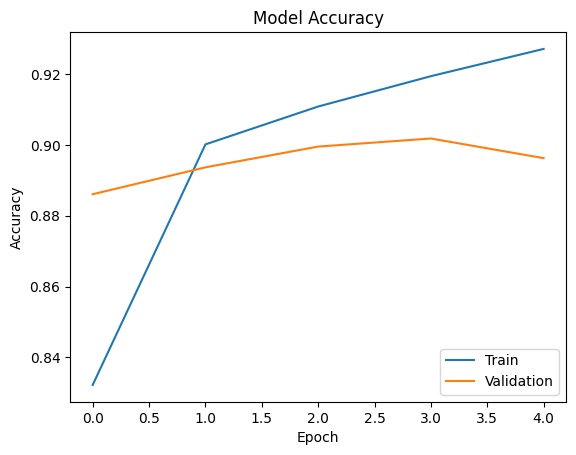

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

1371/1371 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step


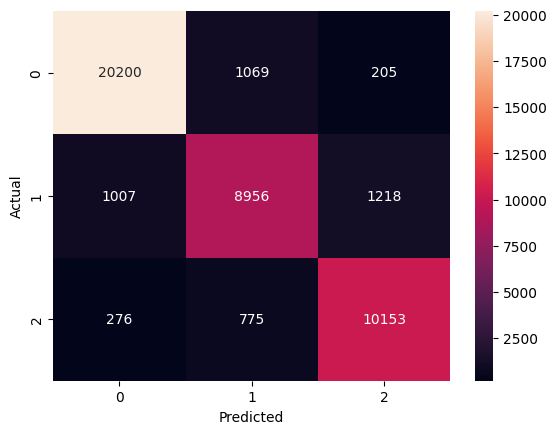

In [19]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
model.save("sentiment_analysis_model.keras")

In [21]:
from tensorflow.keras.models import load_model
model = load_model("sentiment_analysis_model.keras")

In [25]:
text = ["I think that ChatGPT has more room for imporvement, overall it is a great tool and is applicable almost everywhere","I dont think it is a useful tool, i hate it!"]
labels = {
    0: "bad",
    1: "neutral",
    2: "good"
}
for txt in text:
  result = model.predict(pad_sequences(tokenizer.texts_to_sequences([txt]), maxlen=max_len, padding='post'))
  for x,y in labels.items():
    if np.argmax(result) == x:
      print(txt)
      print(y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
I think that ChatGPT has more room for imporvement, overall it is a great tool and is applicable almost everywhere
good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
I dont think it is a useful tool, i hate it!
bad
